<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/causalForest/candy_priceElasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
binary_features_cols = ["chocolate" ,
                   "fruity"    ,
                   "caramel"   ,
                   "peanutyalmondy",
                   'nougat'    ,
                   "crispedricewafer" ,
                   "hard"      ,
                   "bar"       ,
                   "pluribus"
                   ]

#'peanutyalmondy', 'caramel', 'nougat', 'bar'
#'peanutyalmondy', 'caramel', 'chocolate', 'pluribus'
#'peanutyalmondy', 'caramel', 'chocolate', 'bar'

#['fruity', 'pluribus', 'hard']


associated_features_to_chocolate = ['chocolate', 'crispedricewafer', 'fruity', 'hard', 'nougat']

non_feature_cols   = ["competitorname" , "winpercent" , "pricepercent"]

In [3]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [4]:
c1 = data ["fruity"] == 1
c2 = data ["pluribus"] == 1
c = c1 & c2
data [c] [['fruity', 'pluribus', 'hard'] ]

,fruity,pluribus,hard
11,1,1,0
12,1,1,0
13,1,1,0
15,1,1,0
17,1,1,1
18,1,1,0
20,1,1,0
21,1,1,0
26,1,1,1
34,1,1,0


In [5]:
c = data ["chocolate"] == 1
data [c] [['peanutyalmondy', 'caramel', 'chocolate', 'pluribus'] ]

,peanutyalmondy,caramel,chocolate,pluribus
0,0,1,1,0
1,0,0,1,0
5,1,0,1,0
6,1,1,1,0
10,0,0,1,0
22,0,0,1,1
23,0,0,1,0
24,0,0,1,0
25,0,0,1,0
27,0,0,1,1


array([[<Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'caramel'}>],
       [<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'pluribus'}>],
       [<Axes: title={'center': 'hard'}>, <Axes: >]], dtype=object)

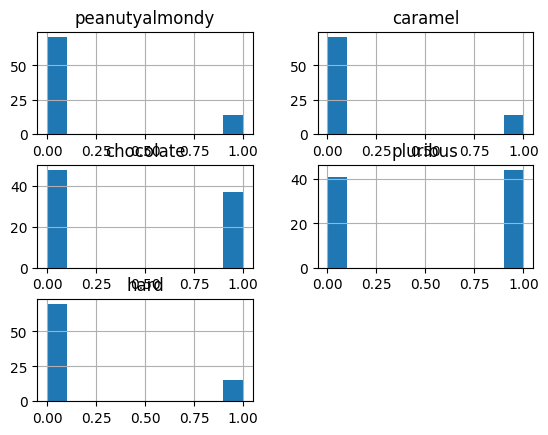

In [90]:
data [['peanutyalmondy', 'caramel', 'chocolate', 'pluribus','hard']].hist ()

In [ ]:
data [['peanutyalmondy', 'caramel', 'chocolate', 'pluribus','hard']]

In [6]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [7]:
#!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 24.2 MB/s eta 0:00:00


In [112]:
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint

from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


class WeightedGBR(BaseEstimator, RegressorMixin):
    """A custom wrapper for GradientBoostingRegressor to handle sample weights."""
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.gbr = GradientBoostingRegressor(n_estimators=self.n_estimators,
                                             max_depth=self.max_depth,
                                             learning_rate=self.learning_rate,
                                             min_samples_split=self.min_samples_split,
                                             min_samples_leaf=self.min_samples_leaf)

    def fit(self, X, y, sample_weight=None):
        self.gbr.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X):
        return self.gbr.predict(X)


# Load the dataset
candy_data = pd.read_csv("/content/candy-data.csv")

# Define features (confounders), treatment, and outcome
X = candy_data[['chocolate',  'caramel', 'peanutyalmondy' , "pluribus" , 'hard']]
W = candy_data ['sugarpercent'].values.reshape (-1,1)
T = candy_data['pricepercent']
Y = candy_data['winpercent']

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint

weights = np.ones(len(X))
weights += candy_data['peanutyalmondy']  # Increase weight where 'peanutyalmondy' is present
weights += candy_data['caramel']         # Increase weight where 'caramel' is present
weights += candy_data['hard']            # Increase weight where 'hard' is present



# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 7),  # Lower max depth to prevent overfitting to majority class
    'min_samples_split': randint(4, 20),  # Increase minimum samples for a split
    'min_samples_leaf': randint(2, 12),  # Increase minimum samples in a leaf
    'learning_rate': [0.01, 0.05, 0.1, 0.2]  # Learning rate to control the step size
}


# Instantiate the estimator
weighted_gbr =  WeightedGBR()


# Set up the RandomizedSearchCV
random_search_y = RandomizedSearchCV(estimator=weighted_gbr, param_distributions=param_dist ,
                                   n_iter=100, cv=5, verbose=50, random_state=0, n_jobs=-1)

random_search_t = RandomizedSearchCV(estimator=weighted_gbr, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=50, random_state=0, n_jobs=-1)

# Fit the RandomizedSearchCV to find the best parameters
#random_search.fit(X, Y)



# Print the best parameters and the best score
#print("Best Parameters:", random_search.best_params_)
#print("Best Score:", random_search.best_score_)
random_search_y.fit(np.concatenate ([X,W],axis =1), Y , sample_weight=weights)
best_model_y = random_search_y.best_estimator_

# Fit the RandomizedSearchCV for T
random_search_t.fit(np.concatenate ([X,W],axis =1), T , sample_weight=weights)
best_model_t = random_search_t.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [140]:
best_model_y.get_params()

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_samples_leaf': 9,
 'min_samples_split': 13,
 'n_estimators': 311}

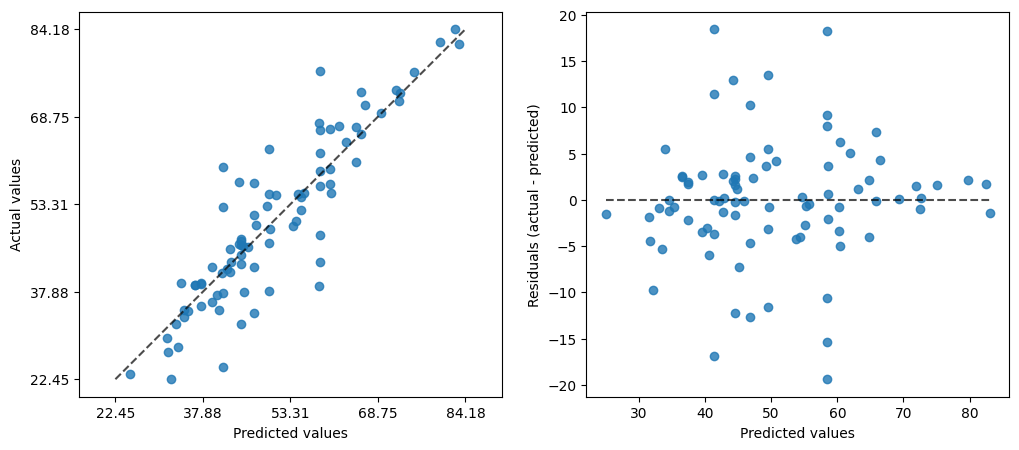

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    best_model_y, np.concatenate ([X,W],axis =1), Y, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    best_model_y, np.concatenate ([X,W],axis =1), Y, kind="residual_vs_predicted", ax=axs[1]
)

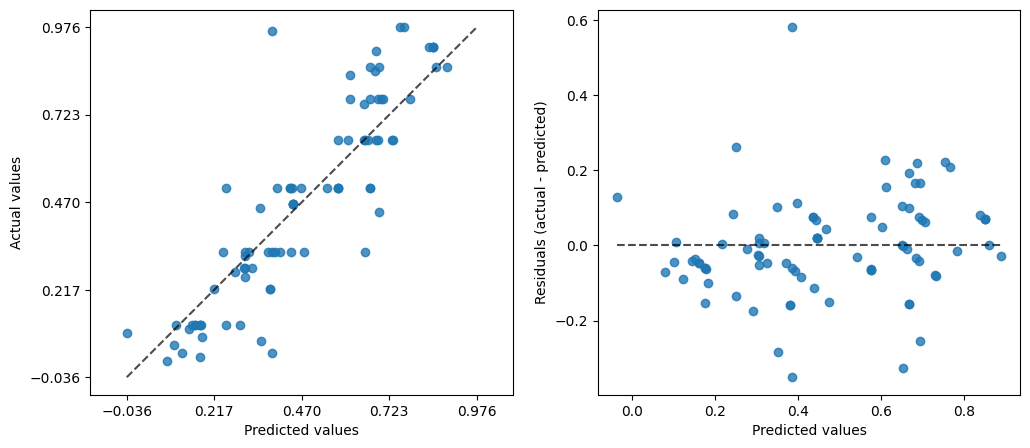

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    best_model_t, np.concatenate ([X,W],axis =1) , T, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    best_model_t, np.concatenate ([X,W],axis =1) , T, kind="residual_vs_predicted", ax=axs[1]
)

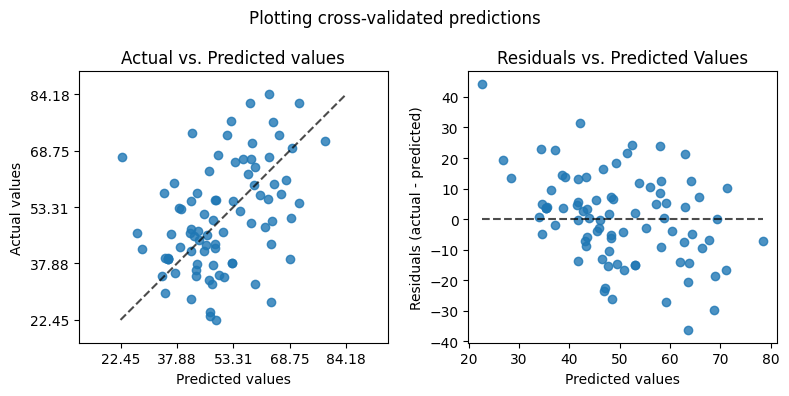

In [128]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

y_pred = cross_val_predict(best_model_y, np.concatenate ([X,W],axis =1), Y, cv=LeaveOneOut ())

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

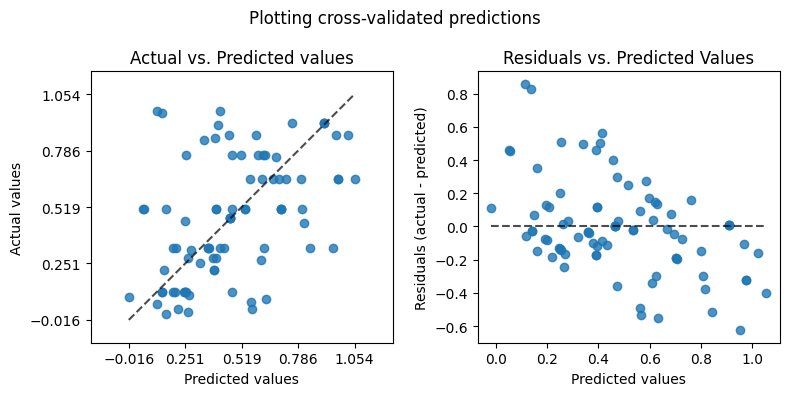

In [127]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

y_pred = cross_val_predict (best_model_y, np.concatenate ([X,W],axis =1), T, cv=LeaveOneOut ())

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    T,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    T,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression

# Define a transformer that simply uses the predictions from the already trained regressor
class PredictionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, trained_regressor):
        self.trained_regressor = trained_regressor

    def fit(self, X, y=None):
        # No fitting necessary as the regressor is already trained
        return self

    def transform(self, X, y=None):
        # Generate predictions from the trained regressor
        predictions = self.trained_regressor.predict(X)
        return predictions.reshape(-1, 1)

# Assuming `weighted_regressor` is your previously trained weighted regressor
prediction_transformer = PredictionTransformer(best_model_y)

# Define your final unweighted regressor
unweighted_regressor = LinearRegression()

# Create a pipeline
pipeline = Pipeline([
    ('feature_augmentation', FeatureUnion([
        ('prediction_feature', prediction_transformer),
        ('original_features', 'passthrough')
    ])),
    ('unweighted_regressor', unweighted_regressor)
])

# Now you can fit and predict with the pipeline
# Note that you do not need to fit the `prediction_transformer` as it uses the already trained regressor
pipeline.fit(np.concatenate ([X,W],axis =1), Y)
y_pred = pipeline.predict(np.concatenate ([X,W],axis =1))

# Evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 42.10322459034261


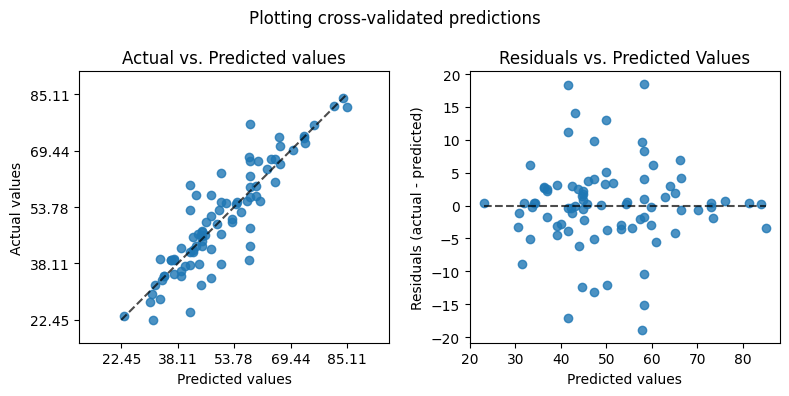

In [143]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

#y_pred = cross_val_predict(pipeline, np.concatenate ([X,W],axis =1), Y, cv=LeaveOneOut ())

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [159]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Define a custom transformer that uses a regressor to transform the data
class RegressorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, regressor):
        self.regressor = regressor

    def fit(self, X, y=None):
        X = pd.DataFrame (X , columns = ['chocolate',  'caramel', 'peanutyalmondy' , "pluribus" , 'hard' , 'sugarpercent'])
        # Compute sample weights based on the input features
        # Assume that 'peanutyalmondy', 'caramel', and 'hard' are columns in X
        self.sample_weight  = np.ones(X.shape[0])
        self.sample_weight += X['peanutyalmondy']
        self.sample_weight += X['caramel']
        self.sample_weight += X['hard']
        X = X.values
        # Fit the regressor using the computed sample weights
        self.regressor.fit(X, y, sample_weight=self.sample_weight)
        return self

    def transform(self, X, y=None):
        # Returns the predicted values as a new feature
        predictions = self.regressor.predict(X)
        return predictions.reshape(-1, 1)

# Define your weighted regressor with sample weights
weighted_regressor_transformer = RegressorTransformer(
    GradientBoostingRegressor(random_state=0)  # Assuming 'weights' are precomputed sample weights
)

# Define your final regressor without sample weights
final_regressor = GradientBoostingRegressor()

# Create a pipeline that combines the two
pipeline = Pipeline([
    ('feature_union', FeatureUnion([
        ('weighted_regressor', weighted_regressor_transformer),
        ('original_features', 'passthrough')  # Keep the original features
    ])),
    ('final_regressor', final_regressor)
])

#param_dist
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 7),  # Lower max depth to prevent overfitting to majority class
    'min_samples_split': randint(4, 20),  # Increase minimum samples for a split
    'min_samples_leaf': randint(2, 12),  # Increase minimum samples in a leaf
    'learning_rate': [0.01, 0.05, 0.1, 0.2]  # Learning rate to control the step size
}


# Now you can fit and predict with the pipeline
pipeline.fit(np.concatenate ([X,W],axis =1), Y)
y_pred = pipeline.predict(np.concatenate ([X,W],axis =1))

# Evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 20.498391780747777


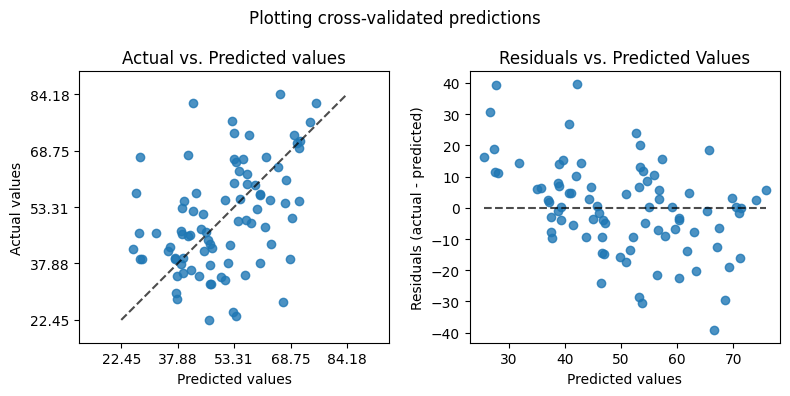

In [160]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

y_pred = cross_val_predict(pipeline, np.concatenate ([X,W],axis =1), Y, cv=LeaveOneOut ())

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    Y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [165]:
class RegressorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, regressor=None, peanutyalmondy_weight=1, caramel_weight=1, hard_weight=1):
        self.regressor = regressor
        self.peanutyalmondy_weight = peanutyalmondy_weight
        self.caramel_weight = caramel_weight
        self.hard_weight = hard_weight

    def fit(self, X, y=None):
        X = pd.DataFrame (X , columns = ['chocolate',  'caramel', 'peanutyalmondy' , "pluribus" , 'hard' , 'sugarpercent'])

        # Check for pandas DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input X must be a pandas DataFrame.")

        # Compute sample weights based on the input features and additional weights
        self.sample_weight = np.ones(len(X))
        self.sample_weight += X['peanutyalmondy'] * self.peanutyalmondy_weight
        self.sample_weight += X['caramel'] * self.caramel_weight
        self.sample_weight += X['hard'] * self.hard_weight

        X =  X.values
        self.regressor.fit(X, y, sample_weight=self.sample_weight)
        return self

    def transform(self, X, y=None):
        predictions = self.regressor.predict(X)
        return predictions.reshape(-1, 1)


In [166]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint

# Assuming RegressorTransformer is defined to accept dynamic weight adjustments

# Define the pipeline
pipeline = Pipeline([
    ('feature_union', FeatureUnion([
        ('weighted_regressor', RegressorTransformer(GradientBoostingRegressor(random_state=0))),
        ('original_features', 'passthrough')
    ])),
    ('final_regressor', GradientBoostingRegressor(random_state=0))
])

# Define the parameter distribution including weight adjustments and model parameters
param_dist = {
    'feature_union__weighted_regressor__peanutyalmondy_weight': [1, 2, 3],
    'feature_union__weighted_regressor__caramel_weight': [1, 2, 3],
    'feature_union__weighted_regressor__hard_weight': [1, 2, 3],
    'final_regressor__n_estimators': randint(100, 500),
    'final_regressor__max_depth': randint(3, 10),
}

# Setup RandomizedSearchCV
search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=100)

search.fit(np.concatenate ([X,W],axis =1), Y)

print("Best parameters:", search.best_params_)
print("Best score:", -search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START feature_union__weighted_regressor__caramel_weight=1, feature_union__weighted_regressor__hard_weight=3, feature_union__weighted_regressor__peanutyalmondy_weight=3, final_regressor__max_depth=9, final_regressor__n_estimators=313
[CV 1/5; 1/10] END feature_union__weighted_regressor__caramel_weight=1, feature_union__weighted_regressor__hard_weight=3, feature_union__weighted_regressor__peanutyalmondy_weight=3, final_regressor__max_depth=9, final_regressor__n_estimators=313;, score=-171.334 total time=   0.4s
[CV 2/5; 1/10] START feature_union__weighted_regressor__caramel_weight=1, feature_union__weighted_regressor__hard_weight=3, feature_union__weighted_regressor__peanutyalmondy_weight=3, final_regressor__max_depth=9, final_regressor__n_estimators=313
[CV 2/5; 1/10] END feature_union__weighted_regressor__caramel_weight=1, feature_union__weighted_regressor__hard_weight=3, feature_union__weighted_regressor__pean

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapse

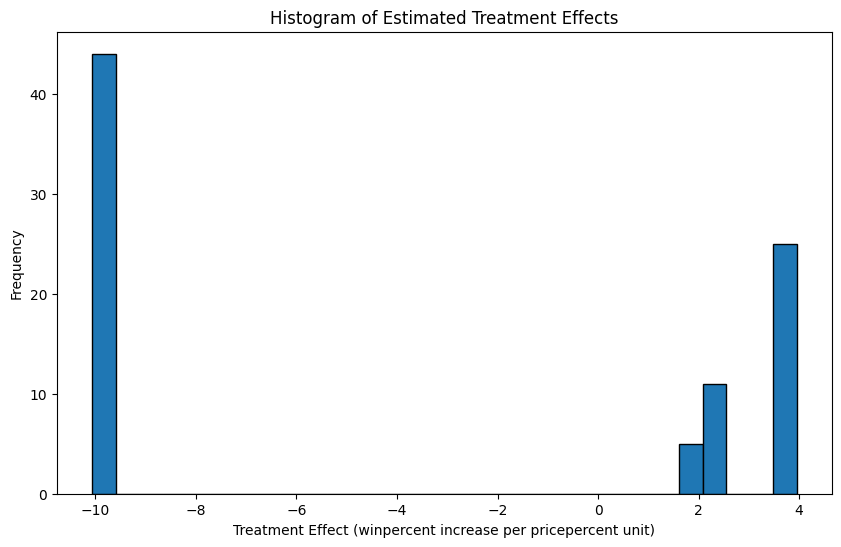

In [132]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

# Instantiate the Causal Forest model
causal_forest = CausalForestDML(model_y=best_model_y,
                                model_t=best_model_t,
                                cv=10,
                                verbose = 50,
                                random_state=123)


# Fit the model
causal_forest.fit(Y, T, X=X , W=W , sample_weight = weights)
#causal_forest.tune (Y, T, X=X , W=W)


# Estimate the causal effect
te_est = causal_forest.effect(X)

# Plot the estimated treatment effect
plt.figure(figsize=(10, 6))
plt.hist(te_est, bins=30, edgecolor='k')
plt.title('Histogram of Estimated Treatment Effects')
plt.xlabel('Treatment Effect (winpercent increase per pricepercent unit)')
plt.ylabel('Frequency')
plt.show()

In [133]:
causal_forest.tunable_params

['n_estimators',
 'criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'min_var_fraction_leaf',
 'min_var_leaf_on_val',
 'max_features',
 'min_impurity_decrease',
 'max_samples',
 'min_balancedness_tol',
 'honest',
 'inference',
 'fit_intercept',
 'subforest_size']

Population summary results are available only if `cache_values=True` at fit time!
Doubly Robust ATE on Training Data Results:  Doubly Robust ATE calculation on training data is available only on discrete treatments!
Doubly Robust ATT on Training Data Results:  Doubly Robust ATT calculation on training data is available only on discrete treatments!


In [134]:
[mdl.score(np.concatenate ([X,W],axis =1),Y) for mdls in causal_forest.models_y for mdl in mdls]

[0.6917306488909394,
 0.7344230034610483,
 0.7539157782300561,
 0.766735310159211,
 0.7833313669819509,
 0.7704181287851862,
 0.7780932446867661,
 0.7567812725129769,
 0.650615372976831,
 0.7532667579391913]

In [135]:
[mdl.score(np.concatenate ([X,W],axis =1),T) for mdls in causal_forest.models_t for mdl in mdls]

[0.7232399360790149,
 0.722544141744325,
 0.668891311615245,
 0.5745405768956209,
 0.6533218198891422,
 0.7599933094531571,
 0.6526270497344255,
 0.7237847616680888,
 0.6351720471241573,
 0.7297246559999695]

In [136]:
causal_forest.const_marginal_effect(X).shape

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

(85,)

In [137]:
causal_forest.feature_importances()

array([0.32570326, 0.00828642, 0.        , 0.65622751, 0.0097828 ])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

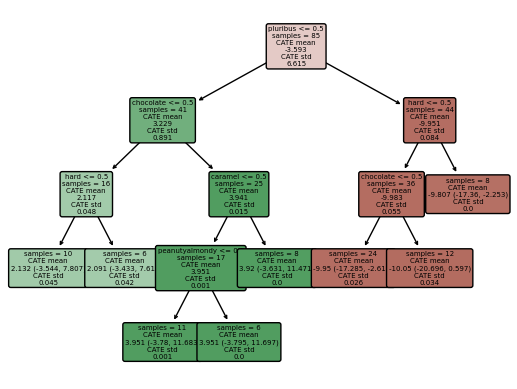

In [138]:
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML
#est = LinearDML()
#est.fit(Y, T, X=X)
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=100, min_samples_leaf=5)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(causal_forest, X)
# Plot the tree
intrp.plot(feature_names=X.columns, fontsize=5)